# HW 5 Problem 3

In [1]:
# Import necessary packages
import pandas as pd
import numpy as np
import statsmodels.api as sm
import tensorflow as tf

import matplotlib.pyplot as plt
%matplotlib inline


# utility function
def reset_graph(seed=42):
    # to make results reproducible across runs
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)
    

# To plot pretty figures
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

/Users/Elizabeth.Ke.Zhang/anaconda/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


## 1 Load the datasets and build models with statsmodels and tensorflow.
(1) Read the banking call reports datasets data_FDIC_learn.h5 to pandas. Build a logistic regression model in statsmodels.

In [2]:
# Load dataset into pandas dataframe.
df = pd.read_hdf('df_FDIC_learn.h5',key='df')
print(df.shape)
df.head(5)

(37754, 52)


Financial Institution Name Institution Name   total_assets  \
IDRSSD date                                                                    
2376   2001-03-31       ORITANI SAVINGS BANK               NaN      659201.0   
       2001-06-30       ORITANI SAVINGS BANK               NaN      666399.0   
       2001-09-30       ORITANI SAVINGS BANK               NaN      698914.0   
       2001-12-31       ORITANI SAVINGS BANK               NaN      710083.0   
       2002-03-31       ORITANI SAVINGS BANK               NaN      734397.0   

                   defaulter Failure / Assistance  transaction_type  \
IDRSSD date                                                           
2376   2001-03-31          0                   NaN              NaN   
       2001-06-30          0                   NaN              NaN   
       2001-09-30          0                   NaN              NaN   
       2001-12-31          0                   NaN              NaN   
       2002-03-31          0                   NaN              NaN   

                   closing_cost         closure_date    log_TA  NI_to_TA  \
IDRSSD date                                                                
2376   2001-03-31           NaN -9223372036854775808  1.082729  0.189800   
       2001-06-30           NaN -9223372036854775808  1.090718  0.124079   
       2001-09-30           NaN -9223372036854775808  1.125763  0.233606   
       2001-12-31           NaN -9223372036854775808  1.137426  0.185885   
       2002-03-31           NaN -9223372036854775808  1.162194  0.278015   

                         ...         FDIC_assessment_base  \
IDRSSD date              ...                                
2376   2001-03-31        ...                     574503.0   
       2001-06-30        ...                     579987.0   
       2001-09-30        ...                     608561.0   
       2001-12-31        ...                     619608.0   
       2002-03-31        ...                     641681.0   

                   tangible_equity_plus_1Q  FDIC_assessment_base_plus_1Q  \
IDRSSD date                                                                
2376   2001-03-31                  86412.0                      579987.0   
       2001-06-30                  90353.0                      608561.0   
       2001-09-30                  90475.0                      619608.0   
       2001-12-31                  92716.0                      641681.0   
       2002-03-31                  94356.0                      676964.0   

                   tangible_equity_n  FDIC_assessment_base_n  \
IDRSSD date                                                    
2376   2001-03-31          -0.017497               -0.030591   
       2001-06-30          -0.016659               -0.030385   
       2001-09-30          -0.014733               -0.029315   
       2001-12-31          -0.014673               -0.028902   
       2002-03-31          -0.013578               -0.028075   

                   tangible_equity_plus_1Q_n  FDIC_assessment_base_plus_1Q_n  \
IDRSSD date                                                                    
2376   2001-03-31                  -0.017679                       -0.030963   
       2001-06-30                  -0.015795                       -0.029908   
       2001-09-30                  -0.015737                       -0.029500   
       2001-12-31                  -0.014666                       -0.028686   
       2002-03-31                  -0.013882                       -0.027383   

                   default_within_1Y  Failure  max_total_assets  
IDRSSD date                                                      
2376   2001-03-31                0.0      NaN         3488632.0  
       2001-06-30                0.0      NaN         3488632.0  
       2001-09-30                0.0      NaN         3488632.0  
       2001-12-31                0.0      NaN         3488632.0  
       2002-03-31                0.0      NaN         34886

In [3]:
predictors = ['log_TA', 'NI_to_TA', 'Equity_to_TA', 'NPL_to_TL', 'core_deposits_to_TA',
'brokered_deposits_to_TA', 'liquid_assets_to_TA','FDIC_assessment_base_n',
'term_spread', 'stock_mkt_growth', 'bbb_spread_change']

In [4]:
reset_graph(seed=42)

df = df.replace(np.nan, 0)
df_positive = df.loc[df['default_within_1Y'] != 0]
print("Default events number is", df_positive.shape[0])

df_negative = df[~df.isin(df_positive).all(1)]
df_negative_sample = df_negative.sample(500)
print("Non-default events number is", df_negative_sample.shape[0])

df_1 = pd.concat([df_positive, df_negative_sample])

delete = ['Equity_to_TA', 'liquid_assets_to_TA', 'stock_mkt_growth']
predictors_v2 = [x for x in predictors if x not in delete]
X = df_1[predictors_v2]
Y = df_1['default_within_1Y']

train_test_split = 4
n_points = df_1.shape[0]
n_test = n_points//4
n_train = n_points - n_test

msk = np.random.rand(len(df_1)) < 0.75

X_train = X[msk].as_matrix()
Y_train = Y[msk].as_matrix().reshape((-1,1))

X_test = X[~msk].as_matrix()
Y_test = Y[~msk].as_matrix().reshape((-1,1))

Default events number is 1426
Non-default events number is 500


## 1.1 Build model with statsmodels.

We can see the results by using result.summary2() function.

In [5]:
model = sm.Logit(Y_train, X_train)
result = model.fit()
result.summary2()

Optimization terminated successfully.
         Current function value: 0.266666
         Iterations 8


<class 'statsmodels.iolib.summary2.Summary'>
"""
                        Results: Logit
===============================================================
Model:              Logit            No. Iterations:   8.0000  
Dependent Variable: y                Pseudo R-squared: 0.534   
Date:               2018-03-23 20:04 AIC:              790.9305
No. Observations:   1453             BIC:              833.1816
Df Model:           7                Log-Likelihood:   -387.47 
Df Residuals:       1445             LL-Null:          -830.78 
Converged:          1.0000           Scale:            1.0000  
-----------------------------------------------------------------
         Coef.    Std.Err.      z      P>|z|     [0.025    0.975]
-----------------------------------------------------------------
x1      -0.5797     0.0645   -8.9838   0.0000   -0.7062   -0.4532
x2      -0.4330     0.0827   -5.2350   0.0000   -0.5951   -0.2709
x3       0.7492     0.0664   11.2816   0.0000    0.6191    0.8794
x4      -0.2668     0.0620   -4.3009   0.0000   -0.3884   -0.1452
x5      -0.0437     0.1246   -0.3503   0.7261   -0.2879    0.2006
x6       0.0855     0.0229    3.7349   0.0002    0.0406    0.1303
x7       0.3350     0.1078    3.1067   0.0019    0.1237    0.5463
x8      -0.0560     0.0720   -0.7773   0.4370   -0.1972    0.0852
===============================================================

"""

## 2. Compute the test error in Statsmodels.

In [6]:
predicted_sm = result.predict(X_test, linear = False)
threshold = 0.5
predicted_binary = (predicted_sm > threshold).astype(int)

from sklearn import metrics
print(metrics.accuracy_score(Y_test, predicted_binary))
print(metrics.roc_auc_score(Y_test, predicted_sm))

0.8985200845665962
0.9311165542101859


## 1.2 Build the model with tensorflow.

Also add the calculation of the train error and test error in the TF implementation of Logistic Regression, and plot the graph.

In [7]:
class Logistic_Regression:
    
    def __init__(self, n_features, learning_rate=0.005):
        
        self.X = tf.placeholder(tf.float32, [None, n_features], name="Input")
        self.X_plus_bias = tf.concat([tf.ones([tf.shape(self.X)[0], 1]), self.X], axis=1)
        
        self.Y = tf.placeholder(tf.float32, [None, 1], name="Target")
        
        self.weights = tf.Variable(tf.random_normal([n_features + 1, 1]))
        self.output = tf.matmul(self.X_plus_bias, self.weights)
        prediction = tf.round(tf.sigmoid(self.output))
        
        
        # Declare loss function
        self.loss = -tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(labels=self.output, logits=self.Y))
        
        # Evaluate the model
        correct = tf.cast(tf.equal(prediction, self.Y), dtype=tf.float32)
            
        # accuracy calculation
        self.accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))
        
        # use Adma optimization for training
        self.train_step = (tf.train.AdamOptimizer(learning_rate).minimize(self.loss), -self.loss)
        
        
        self.output_L1_error = tf.reduce_mean(abs(self.Y - prediction))
        
        self.error = tf.reduce_mean(tf.square(prediction - self.Y))
        
        
        

In [8]:
reset_graph(seed=42)

df = df.replace(np.nan, 0)
df_positive = df.loc[df['default_within_1Y'] != 0]
print("Default events number is", df_positive.shape[0])

df_negative = df[~df.isin(df_positive).all(1)]
df_negative_sample = df_negative.sample(500)
print("Non-default events number is", df_negative_sample.shape[0])

df_1 = pd.concat([df_positive, df_negative_sample])

delete = ['Equity_to_TA', 'liquid_assets_to_TA', 'stock_mkt_growth']
predictors_v2 = [x for x in predictors if x not in delete]
X = df_1[predictors_v2]
Y = df_1['default_within_1Y']

msk = np.random.rand(len(df_1)) < 0.5

X_train = X[msk].as_matrix()
Y_train = Y[msk].as_matrix().reshape((-1,1))

X_test = X[~msk].as_matrix()
Y_test = Y[~msk].as_matrix().reshape((-1,1))



Default events number is 1426
Non-default events number is 500


In [9]:
reset_graph(seed=42)

learning_rate = 0.001
batch_size = 20
iter_num = 1000
n_features = 8

tf_model = Logistic_Regression(n_features=n_features, learning_rate=learning_rate)

# Start training
with tf.Session() as sess:
    
    # Initialize the variables
    sess.run(tf.global_variables_initializer())
    
    losses = []
    history = []
    for i in range(iter_num):
        (_, loss), weights = sess.run((tf_model.train_step, tf_model.weights), feed_dict={
            tf_model.X : X_train,
            tf_model.Y : Y_train})
        
        train_loss = sess.run(tf_model.error, feed_dict={
                    tf_model.X : X_train,
                    tf_model.Y : Y_train,
                    })
        
        test_loss = sess.run(tf_model.error, feed_dict={
                    tf_model.X : X_test,
                    tf_model.Y : Y_test,
                    })

        losses.append(train_loss)
        history.append([train_loss, test_loss])

    output_L1_error = sess.run(tf_model.output_L1_error,
                    feed_dict={tf_model.X: X_test,
                               tf_model.Y: Y_test})
    Y_test_predicted = sess.run(tf_model.output, feed_dict={
        tf_model.X : X_test})
    
    print('Loss:', loss) 
    print("Model fitted parameters: ")
    print(weights)
    print('Test_L1_error', output_L1_error)

Loss: 12.092809
Model fitted parameters: 
[[-2.3482769 ]
 [-0.65732455]
 [ 1.7641997 ]
 [-1.2631778 ]
 [ 1.4808253 ]
 [ 0.16190128]
 [-0.08098546]
 [-1.7946663 ]
 [ 1.2048339 ]]
Test_L1_error 0.77060574


## 3. Plot the calculated train error and test error.

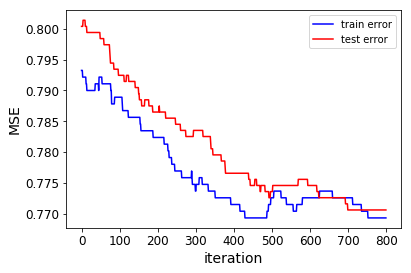

In [10]:
plt.figure()
history = np.array(history)
a, = plt.plot(history[200:,0], c="#0000FF", label="train error")
b, = plt.plot(history[200:,1], c="#ff0000", label="test error")
plt.legend(handles=[a,b])
plt.xlabel("iteration")
plt.ylabel("MSE")
plt.show()